# Bulldozers example

### Initialize & install modules

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
!pip install numpy
!pip install matplotlib
!pip install sklearn
!pip install torch
!pip install nvidia-ml-py3 beautifulsoup4 fastprogress
!pip install bottleneck dataclasses

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from fastai.tabular import *

# Load data

In [3]:
# Download 'Blue book Bulldozer' dataset from Kallgle
data_path = 'data/bulldozer/TrainAndValid.csv'

In [4]:
# When loading, make sure we parse 'saledate' column
df_raw = pd.read_csv(data_path, low_memory=False, parse_dates=['saledate'])

In [5]:
df_ori = df_raw.copy()

### Define dependent variable

In [6]:
dep_var = 'SalePrice'

In [8]:
# Use log of salesprice instead of saleprice (as defined in the problem description)
df_ori.SalePrice = np.log(df_ori.SalePrice)

### Convert categorical entries

In [9]:
# Helper functions

sanitize_valid_chars = set('-_.abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789')

def ifnone(val, val_default):
    "`a` if `a` is not None, otherwise `b`. Source: fast.ai"
    return val_default if val is None else val

def sanitize(s):
    ''' Sanitize a string by only allowing "valid" characters '''
    return ''.join(c for c in str(s) if c in sanitize_valid_chars)

In [10]:
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype

class DfPreproc:
    ''' 
    Data Frame preprocessing. Calculate some field (i.e. dataframe column) transformations
    and store the results in 'columns_to_add' and 'columns_to_remove'. Then apply these
    changes to the original dataframe to create a new dataframe.    
    '''

    def __init__(self, df:DataFrame, columns_date=None, one_hot_max_cardinality:int=7):
        '''
        Parameters:
            df : dataFrame
            columns_date: Columns to be expanded into multiple date/time fields
            one_hot_max_cardinality: Max cardinality (i.e. number of categories) for 'one hot' encoding.
        '''
        self.df = df
        self.one_hot_max_cardinality = one_hot_max_cardinality
        self.columns_date = ifnone(columns_date, set())
        self.df_new = None
        self.categories = dict()
        self.columns_to_add = dict()
        self.columns_to_remove = set()

    def add_datepart(self, field_name:str, prefix:str=None, time:bool=True):
        '''
        Helper function that creates a new dataframe with all columns relevant to
        a date in the column `field_name`.
        Source: fast.ai 
        '''
        make_date(self.df, field_name)
        field = self.df[field_name]
        prefix = ifnone(prefix, re.sub('[Dd]ate$', '', field_name))
        attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear', 'Is_month_end', 'Is_month_start', 
                'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
        if time:
            attr = attr + ['Hour', 'Minute', 'Second']
        df = pd.DataFrame()
        for n in attr:
            df[prefix + n] = getattr(field.dt, n.lower())
        df[prefix + 'Elapsed'] = field.astype(np.int64) // 10 ** 9
        # Add to replace and remove operations
        self.columns_to_add[field_name] = df
        self.columns_to_remove.add(field_name)

    def category(self, field_name:str):
        " Convert field to category numbers "
        xi = self.df[field_name]
        xi_cat = xi.astype('category').cat.as_ordered()
        self.categories[field_name] = xi_cat
        df_cat = DataFrame()
        df_cat[field_name] = xi_cat.cat.codes
        # Add to replace and remove operations
        self.columns_to_add[field_name] = df_cat
        self.columns_to_remove.add(field_name)

    def create(self):
        """ Create a new dataFrame based on the previously calculated conversions """
        # Create new dataFrame
        df_new = self.df.copy()
        # Drop old columns categorical columns
        df_new.drop(list(self.columns_to_remove), axis=1, inplace=True)
        # Join new columns
        for c in self.columns_to_add:
            df_new = df_new.join(self.columns_to_add[c])
        self.df_new = df_new
        return df_new

    def make_date(self, df:DataFrame, date_field:str):
        " Make sure `df[field_name]` is of the right date type. Source: fast.ai "
        field_dtype = df[date_field].dtype
        if isinstance(field_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
            field_dtype = np.datetime64
        if not np.issubdtype(field_dtype, np.datetime64):
            df[date_field] = pd.to_datetime(df[date_field], infer_datetime_format=True)

    def na(self, field_name:str):
        " Process 'na' columns (i.e missing data) "
        # Add '*_na' column
        xi = self.df[field_name].copy()
        df_na = DataFrame()
        df_na[f"{field_name}_na"] = xi.isna().astype('int8')
        # Replace missing values by median
        replace_value = xi.median()
        xi[xi.isna()] = replace_value
        df_na[field_name] = xi
        # Add operations
        self.columns_to_add[field_name] = df_na
        self.columns_to_remove.add(field_name)

    def new(self):
        " Preprocess and create a new dataframe from pre-processing transformations "
        self.preprocess()
        return self.create()

    def one_hot(self, field_name:str, has_na:bool):
        " Create a one hot encodig for 'field_name' "
        df_one_hot = pd.get_dummies(self.df[field_name], dummy_na=has_na)
        self.rename_category_cols(df_one_hot, f"{field_name}_")
        # Add to transformations
        self.columns_to_add[field_name] = df_one_hot
        self.columns_to_remove.add(field_name)

    def preprocess(self):
        '''
        Perform data frame pre-processing steps:
            - Convert categorical data
            - Convert on-hot encoding
            - Convert dates into multiple columns
        
        '''
        for c in self.df.columns:
            xi = self.df[c]
            has_na = (xi.isna().sum() > 0)

            if c in self.columns_date:
                self.add_datepart(c)
                if has_na:
                    print(f"{c}: date part + NA {xi.dtype}")
                    self.na(c)
                else:
                    print(f"{c}: date part")
            elif xi.dtype == 'O':
                values = xi.unique()
                count_cats = len(values)
                # Create transformations to convert field (column)
                if count_cats <= self.one_hot_max_cardinality:
                    print(f"{c}: one hot")
                    self.one_hot(c, has_na)
                elif pd.api.types.is_string_dtype(xi):
                    print(f"{c}: category")
                    self.category(c)
                else:
                    print(f"{c}: ok {xi.dtype}")                    
            else:
                if has_na:
                    print(f"{c}: NA {xi.dtype}")
                    self.na(c)
                else:
                    print(f"{c}: ok {xi.dtype}")

    def rename_category_cols(self, df, prepend):
        '''
        Rename dataFrame columns by prepending a string and sanitizing the name
        Used to rename columns of a 'one hot' encoding
        '''
        names = dict()
        for c in df.columns:
            name = f"{prepend}{sanitize(c)}"
            names[c] = name
        df.rename(columns=names, inplace=True)



In [11]:
dfpp = DfPreproc(df_ori, columns_date=['saledate'])
df = dfpp.new()

SalesID: ok int64
SalePrice: ok float64
MachineID: ok int64
ModelID: ok int64
datasource: ok int64
auctioneerID: NA float64
YearMade: ok int64
MachineHoursCurrentMeter: NA float64
UsageBand: one hot
saledate: date part
fiModelDesc: category
fiBaseModel: category
fiSecondaryDesc: category
fiModelSeries: category
fiModelDescriptor: category
ProductSize: one hot
fiProductClassDesc: category
state: category
ProductGroup: one hot
ProductGroupDesc: one hot
Drive_System: one hot
Enclosure: one hot
Forks: one hot
Pad_Type: one hot
Ride_Control: one hot
Stick: one hot
Transmission: category
Turbocharged: one hot
Blade_Extension: one hot
Blade_Width: one hot
Enclosure_Type: one hot
Engine_Horsepower: one hot
Hydraulics: category
Pushblock: one hot
Ripper: one hot
Scarifier: one hot
Tip_Control: one hot
Tire_Size: category
Coupler: one hot
Coupler_System: one hot
Grouser_Tracks: one hot
Hydraulics_Flow: one hot
Track_Type: one hot
Undercarriage_Pad_Width: category
Stick_Length: category
Thumb: on

### Split into training and validation

In [12]:
x, y = df.drop(dep_var, axis=1), df[dep_var]

In [13]:
x.head().transpose()

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
YearMade,2004,1996,2001,2001,2007
auctioneerID_na,0,0,0,0,0
auctioneerID,3,3,3,3,3
MachineHoursCurrentMeter_na,0,0,0,0,0
MachineHoursCurrentMeter,68,4640,2838,3486,722
UsageBand_High,0,0,1,1,0


In [16]:
# Sub-sample training set for speed
train_subset = 50_000
validate_subset = 12_000

tv = train_subset + validate_subset
x_train = x[-tv:-validate_subset]
y_train = y[-tv:-validate_subset]

# Validate
x_val = x[-validate_subset:]
y_val = y[-validate_subset:]

print(f"Trainig set: {len(x_train)}\tValidation set:{len(x_val)}")

Trainig set: 50000	Validation set:12000


# Train

In [17]:
# Functions to show training results

def rmse(x, y): return math.sqrt(((x - y)**2).mean())

def print_score(m):
    ret = [rmse(m.predict(x_train), y_train), rmse(m.predict(x_val), y_val), m.score(x_train, y_train), m.score(x_val, y_val)]
    print(ret)
    return ret

### Model with a single tree

In [25]:
# Train model: Zero (exploratory analysis)
m = RandomForestRegressor(n_jobs=-1, n_estimators=1, bootstrap=False)
m.fit(x_train, y_train)
print_score(m)

# Note: We should fit perfectly the test dataset

[1.293207299340885e-16, 0.3871013328599321, 1.0, 0.7253088791260216]


[1.293207299340885e-16, 0.3871013328599321, 1.0, 0.7253088791260216]

### Model with single (shallow) tree for interpretation

In [ ]:
# Train model: Zero (exploratory analysis)
m = RandomForestRegressor(n_jobs=-1, n_estimators=1, max_depth=3, bootstrap=False)
m.fit(x_train, y_train)
print_score(m)

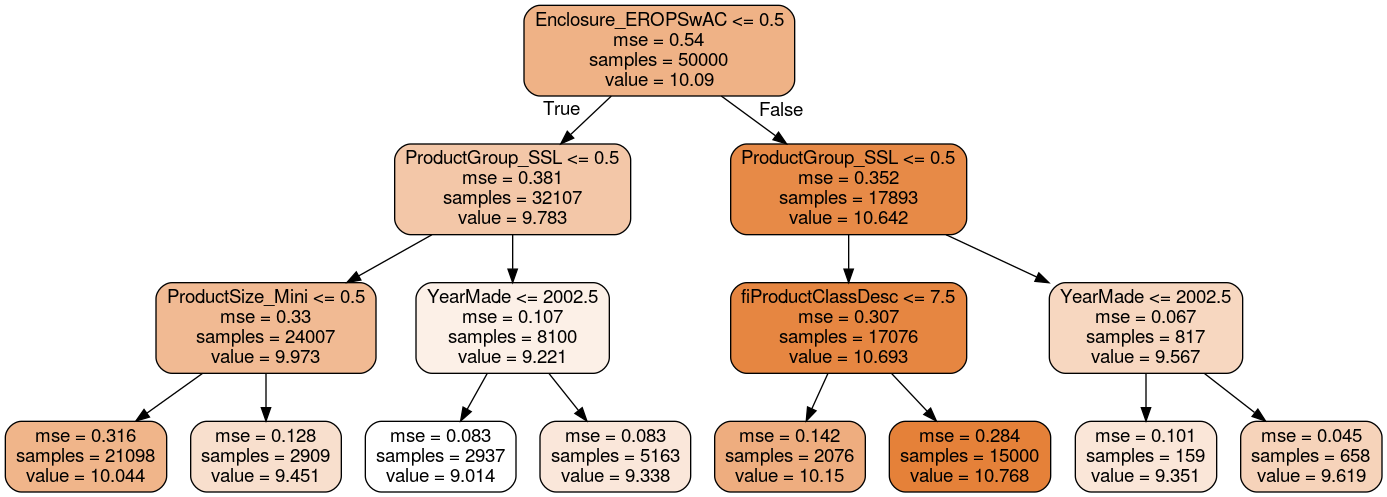

In [19]:
# Export the tree to a graphviz 'dot' format
from sklearn.tree import export_graphviz
from IPython import display

str_tree = export_graphviz(m.estimators_[0],
                           out_file='tree.dot',
                           feature_names=x_train.columns,
                           filled=True,
                           rounded=True)

# Convert 'dot' to 'png'
!dot -Tpng 'tree.dot' -o 'tree.png'

# Show image
from IPython.display import Image
Image(filename='tree.png') 

### Model with 10 trees

In [20]:
m = RandomForestRegressor(n_jobs=-1, n_estimators=10)
%time m.fit(x_train, y_train)
print_score(m)

CPU times: user 11.1 s, sys: 112 ms, total: 11.2 s
Wall time: 3.51 s
[0.09915418180679904, 0.2795054842858964, 0.9817882865352621, 0.8567891390319846]


[0.09915418180679904,
 0.2795054842858964,
 0.9817882865352621,
 0.8567891390319846]

### Model with  more trees and more randomness

In [27]:
m = RandomForestRegressor(n_jobs=-1, n_estimators=40, min_samples_leaf=3, max_features=0.5)
%time m.fit(x_train, y_train)
print_score(m)

CPU times: user 23.6 s, sys: 142 ms, total: 23.7 s
Wall time: 7.13 s
[0.1291346903431398, 0.25971418796605794, 0.9691102360761268, 0.8763521301366206]


[0.1291346903431398,
 0.25971418796605794,
 0.9691102360761268,
 0.8763521301366206]

### Exploratory analysis

**Note**: Lesson 3, time 1:00

**TO DO** Calculate the std of the prediction

**TO DO**: Then prediction std within groups (e.g. in categorical data)

In [32]:
preds = np.stack([t.predict(x_val) for t in m.estimators_])

In [45]:
sample_num = 0
print(f"predictions: {preds[sample_num]}")
print(f"mean       : {np.mean(preds[:,sample_num])}")
print(f"std        : {np.std(preds[:,sample_num])}")


predictions: [10.521869 10.449867 11.021311 10.748774 ...  9.405883  9.188916  9.177554  9.673799]
mean       : 10.504929108507122
std        : 0.30434522265553615


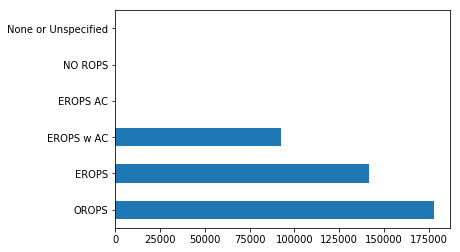

In [31]:
df_raw.Enclosure.astype('category').cat.as_ordered().value_counts().plot.barh()

# Feature importance

In [50]:
def feature_importance(x, y, m):
    xc = x.copy()
    for c in x:
        print(c)
        xi = xc[c]
    pass

In [51]:
feature_importance(x_val, y_val, m)

SalesID
MachineID
ModelID
datasource
YearMade
auctioneerID_na
auctioneerID
MachineHoursCurrentMeter_na
MachineHoursCurrentMeter
UsageBand_High
UsageBand_Low
UsageBand_Medium
UsageBand_nan
saleYear
saleMonth
saleWeek
saleDay
saleDayofweek
saleDayofyear
saleIs_month_end
saleIs_month_start
saleIs_quarter_end
saleIs_quarter_start
saleIs_year_end
saleIs_year_start
saleHour
saleMinute
saleSecond
saleElapsed
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize_Compact
ProductSize_Large
ProductSize_LargeMedium
ProductSize_Medium
ProductSize_Mini
ProductSize_Small
ProductSize_nan
fiProductClassDesc
state
ProductGroup_BL
ProductGroup_MG
ProductGroup_SSL
ProductGroup_TEX
ProductGroup_TTT
ProductGroup_WL
ProductGroupDesc_BackhoeLoaders
ProductGroupDesc_MotorGraders
ProductGroupDesc_SkidSteerLoaders
ProductGroupDesc_TrackExcavators
ProductGroupDesc_TrackTypeTractors
ProductGroupDesc_WheelLoader
Drive_System_AllWheelDrive
Drive_System_FourWheelDrive
Drive_System_No
Dri

In [52]:
xi = x.Blade_Type

0        -1
1        -1
2        -1
3        -1
4        -1
5        -1
6        -1
7        -1
8        -1
9        -1
10       -1
11        5
12       -1
13       -1
14       -1
15       -1
16       -1
17       -1
18       -1
19       -1
20       -1
21       -1
22       -1
23       -1
24       -1
25       -1
26       -1
27       -1
28       -1
29       -1
         ..
412668   -1
412669   -1
412670   -1
412671   -1
412672   -1
412673   -1
412674   -1
412675   -1
412676   -1
412677   -1
412678   -1
412679   -1
412680   -1
412681   -1
412682   -1
412683   -1
412684   -1
412685   -1
412686   -1
412687   -1
412688   -1
412689   -1
412690   -1
412691   -1
412692   -1
412693   -1
412694   -1
412695   -1
412696   -1
412697   -1
Name: Blade_Type, Length: 412698, dtype: int8